In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances
import GPy
import matplotlib.pyplot as plt
import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Сгенерируем 1000 точек x_i

x = np.linspace (0,10,1000)

In [3]:
import utility

In [4]:
sample_size = 1200
points = np.linspace(0, 1, sample_size).reshape(-1, 1)
first_L = 15
first_theta = (first_L ** 0.5) / (3 ** 0.5)
covariance_matrix = utility.get_covariance_matern_12(points, {'theta' : first_theta, 'noise_variance' : 1e-16})

In [5]:
print (covariance_matrix)

[[1.00000001 0.99813679 0.99627706 ... 0.10727731 0.10707743 0.10687793]
 [0.99813679 1.00000001 0.99813679 ... 0.10747757 0.10727731 0.10707743]
 [0.99627706 0.99813679 1.00000001 ... 0.10767819 0.10747757 0.10727731]
 ...
 [0.10727731 0.10747757 0.10767819 ... 1.00000001 0.99813679 0.99627706]
 [0.10707743 0.10727731 0.10747757 ... 0.99813679 1.00000001 0.99813679]
 [0.10687793 0.10707743 0.10727731 ... 0.99627706 0.99813679 1.00000001]]


In [6]:
cholesky_covariance = np.linalg.cholesky(covariance_matrix)

In [7]:
values = np.random.randn(sample_size, 1)
values = np.dot(cholesky_covariance, values)

In [8]:
a = []
b = []
for i in range (120):
    a = np.append (a, points[10*i])
    b = np.append (b, values[10*i])

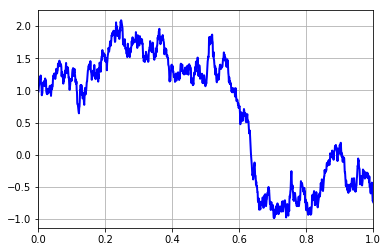

In [9]:
plt.plot(points, values, color = 'b', linewidth=2)
plt.xlim(0,1)
plt.grid ("True")

In [10]:
def f(x, h):
    if (x==0):
        res = 1/h
    else:
        res = h* (np.sin(np.pi*x/h)/(np.pi*x))**2
    return res

In [11]:
def g(x):
    res = 0
    for i in range (120):
        res = res + f(x-a[i], 1/120.)*b[i]
    return res/120.

In [12]:
y = []
z = []
v = np.linspace(0, 1, 1200).reshape(-1, 1)
for i in range (1200):
    y = np.append (y, g(v[i]))
    z = np.append (z, g(v[i]))

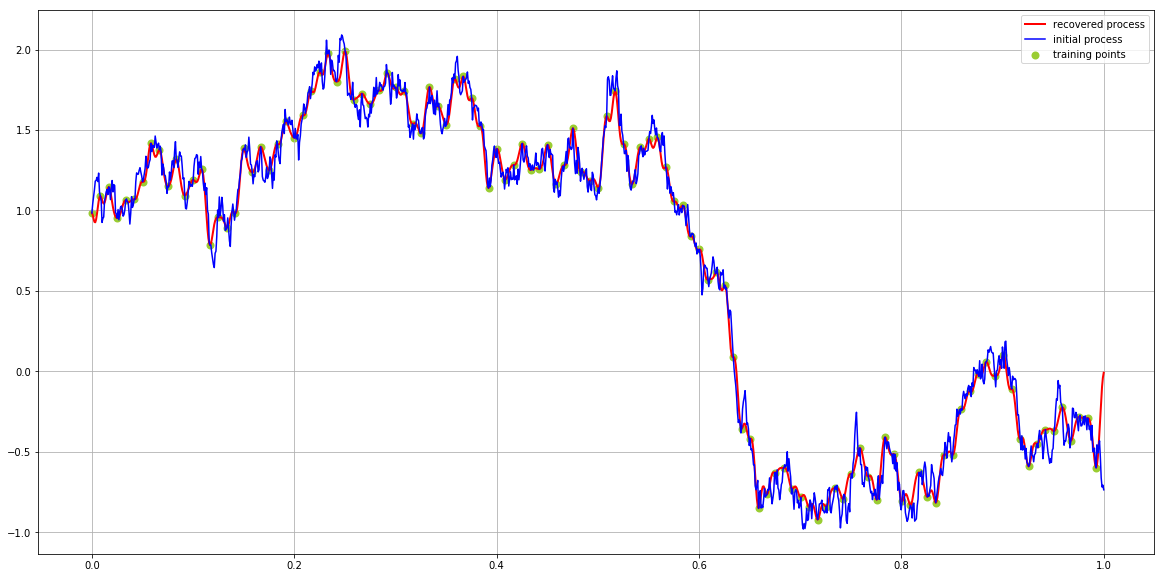

In [13]:
import pylab
fig, ax = plt.subplots (figsize = [20, 10])
plt.scatter (a, b, color = 'yellowgreen', marker = 'o', lw = 2, label = 'training points')
plt.plot (v, y, color = 'red', lw = 2, label ='recovered process')
plt.plot (points, values, color = 'b', label = 'initial process')
plt.legend (loc = 'best')
plt.grid('True')
pylab.savefig ('Process.png')

# Сравниваем разные регрессионные модели

{'dataplot': [<matplotlib.collections.PathCollection at 0x1c975224f28>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1c975224e10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1c975233278>]}

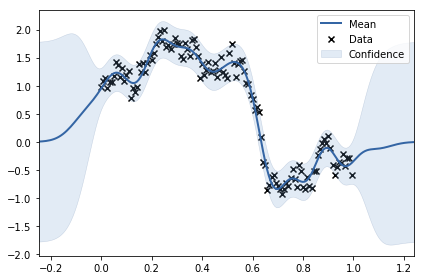

In [14]:
kern = GPy.kern.ExpQuad(1)
a = a.reshape(a.shape[0], 1)
b = b.reshape(b.shape[0], 1)
model = GPy.models.GPRegression(a, b, kern)
model.optimize()
model.plot()

In [15]:
y = []
v = np.linspace(0, 1, 1200).reshape(-1, 1)
for i in range (1200):
    xx = v[i].reshape(v[i].shape[0], 1)
    y = np.append (y, float(model.predict(xx)[0]))

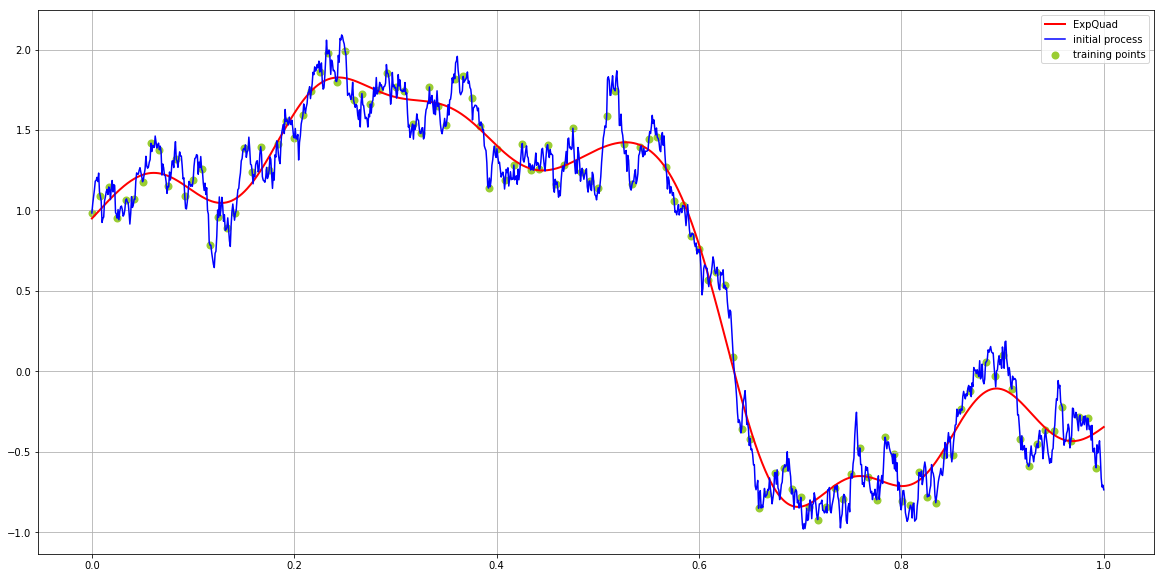

In [16]:
import pylab
fig, ax = plt.subplots (figsize = [20, 10])
plt.scatter (a, b, color = 'yellowgreen', marker = 'o', lw = 2, label = 'training points')
plt.plot (v, y, color = 'red', lw = 2, label ='ExpQuad')
plt.plot (points, values, color = 'b', label = 'initial process')
plt.legend (loc = 'best')
plt.grid('True')
pylab.savefig ('Process.png')

In [17]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [18]:
print (MSE(z, values))
print (MSE(y, values))

0.008597536899735263
0.02259404684739046


# Тесты

In [19]:
def f(x, h):
    if (x==0):
        res = 1/h
    else:
        res = h* (np.sin(np.pi*x/h)/(np.pi*x))**2
    return res

In [20]:
def g(x,h):
    res = 0
    for i in range (h):
        res = res + f(x-a[i], 1/h)*b[i]
    return res/h

In [25]:
kern_name = [GPy.kern.Exponential, GPy.kern.Matern32,
            GPy.kern.Matern52, GPy.kern.ExpQuad, GPy.kern.PeriodicMatern32, GPy.kern.Minimax] #ядра гауссовских процессов

df = pd.DataFrame(columns=['Exponential', 'Matern32', 'Matern52', 'ExpQuad', 'PeriodicMatern32', 'Minimax', 'Our'])
kk = [40, 80, 100]
ii = 0

for k in kk:
    for m in range (10):
        sample_size = 1200
        first_L = 10+m*80
        points = np.linspace(0, 1, sample_size).reshape(-1, 1)
        first_theta = (first_L ** 0.5) / (3 ** 0.5)
        for n in range (5):
            covariance_matrix = utility.get_covariance_matern_12(points, {'theta' : first_theta, 'noise_variance' : 1e-16})
            cholesky_covariance = np.linalg.cholesky(covariance_matrix)
            values = np.random.randn(sample_size, 1)
            values = np.dot(cholesky_covariance, values)
            for c in range (sample_size):
                values[c] = values[c] + np.random.normal(0, 5*10**(-2))
            error = []
            for kern in kern_name:
                ker = kern(1)
                a = []
                b = []
                for i in range (k):
                    a = np.append (a, points[int(sample_size/k*i)])
                    b = np.append (b, values[int(sample_size/k*i)])
                a = a.reshape(a.shape[0], 1)
                b = b.reshape(b.shape[0], 1)
                model = GPy.models.GPRegression(a, b, ker)
                model.optimize()
                y = []
                v = np.linspace(0, 1, 1200).reshape(-1, 1)
                for i in range (1200):
                    x = v[i].reshape(v[i].shape[0], 1)
                    y = np.append (y, float(model.predict(x)[0]))
                error = np.append(error, MSE(y, values))
            z = []
            v = np.linspace(0, 1, 1200).reshape(-1, 1)
            for i in range (1200):
                z = np.append (z, g(v[i],k))
            error = np.append (error, MSE(z, values))
            df.loc[ii] = error
            print (ii)
            ii = ii + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [26]:
df

,Exponential,Matern32,Matern52,ExpQuad,PeriodicMatern32,Our,Minimax
0,0.020717,0.034358,0.036447,0.093675,0.094566,0.093522,0.031431
1,0.022330,0.030453,0.035518,0.039124,0.049093,0.040017,0.022520
2,0.024545,0.029038,0.031984,0.044546,0.045312,0.111641,0.022737
3,0.020157,0.032250,0.038479,0.083259,0.077094,0.084020,0.056823
4,0.016877,0.022907,0.024467,0.025160,0.031837,0.065637,0.038754
5,0.065318,0.100075,0.120811,0.143813,0.164296,0.144364,0.069517
6,0.052513,0.080056,0.085648,0.131015,0.170520,0.139831,0.061288
7,0.060747,0.067835,0.073432,0.081834,0.235510,0.153200,0.055743
8,0.057687,0.059155,0.060333,0.064570,0.201598,0.176659,0.060534
9,0.046554,0.062845,0.066636,0.068136,0.157272,0.238029,0.050179


# Кривые Долана-Мора

In [27]:
n = int(((df['Exponential']).shape)[0])
print (n)

150


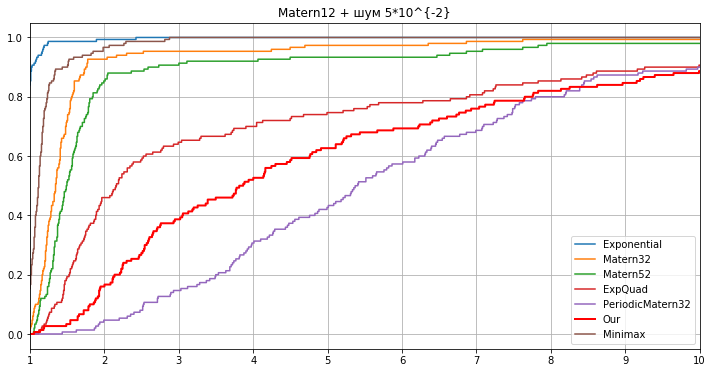

In [28]:
import pylab
plt.figure(figsize=(12, 6))
Names = ['Exponential', 'Matern32', 'Matern52', 'ExpQuad', 'PeriodicMatern32', 'Our', 'Minimax']
x = np.linspace (1, 10, 1000)

for name in Names:
    b = []
    for xx in x:
        num = 0
        for i in range (n):
            j = float(df[name][i])
            if j <= xx*float(df.iloc[i].min()) :
                num = num + 1
        b = np.append (b, num/n)
    if name == 'Our':
        plt.step (x, b, label = name,color = 'r', lw = 2)
    else:
        plt.step (x, b, label = name)
    plt.legend()
plt.title ('Matern12 + шум 5*10^{-2}')
plt.xlim(1,10)
plt.grid()
pylab.savefig('Matern12+noise.png')